In [2]:
import torch
import imp
#import TransformerTrainer
import MyTransformer
import PruningTrainer
imp.reload(PruningTrainer)
imp.reload(MyTransformer)
from PruningTrainer import BaseDataModule, MyPruningTrainer
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning.callbacks import LearningRateMonitor
import random
import numpy as np
import utils
from torch import nn

In [3]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
%env CUBLAS_WORKSPACE_CONFIG :16:8

env: CUBLAS_WORKSPACE_CONFIG=:16:8


In [4]:
DEVICE = "cuda"
BATCH_SIZE = 64
MAX_LEN = 50

torch.manual_seed(SEED)
torch.set_deterministic(True)

data_module = BaseDataModule(
    batch_size=BATCH_SIZE,
    device = DEVICE,
    data_path="./data/eng_rus.txt",
    seed=SEED
)

data_module.prepare_data()

In [5]:
model_params = {
    "src_vocab_size": data_module.src_vocab_len,
    "trg_vocab_size": data_module.trg_vocab_len,
    "d_model": 512,
    "n_enc_layers": 6,
    "n_dec_layers": 6,
    "n_enc_heads": 8,
    "n_dec_heads": 8,
    "enc_dropout": 0.1,
    "dec_dropout": 0.1
}

In [6]:
model = MyTransformer.Transformer(**model_params)
checkpoint = torch.load("models/transformer_model.pt")
model.load_state_dict(checkpoint)
model.to(DEVICE)
pass

In [7]:
plmodel = MyPruningTrainer(
    model, data_module.src_pad_idx, data_module.trg_pad_idx, 1e-4
)
plmodel.to(DEVICE)
pass

In [13]:
N_EPOCHS = 10
CLIP = 1
plmodel.lr = 1e-4

tb_logger = pl_loggers.TensorBoardLogger('./logs/')
lr_monitor = LearningRateMonitor(logging_interval='step')
early_stop_callback = EarlyStopping(
   monitor='total_val_loss',
   min_delta=0.01,
   patience=2,
   verbose=False,
   mode='mean'
)
trainer = Trainer(
    max_epochs=N_EPOCHS,
    gradient_clip_val=CLIP,
    progress_bar_refresh_rate=1,
    callbacks=[lr_monitor], 
    logger=tb_logger,
    log_every_n_steps=20
)
data_module.setup('fit')
trainer.fit(plmodel, data_module)

GPU available: True, used: False
TPU available: None, using: 0 TPU cores

  | Name      | Type             | Params
-----------------------------------------------
0 | criterion | CrossEntropyLoss | 0     
1 | model     | Transformer      | 57.1 M
2 | pruner    | Pruner           | 180   
-----------------------------------------------
57.1 M    Trainable params
36        Non-trainable params
57.1 M    Total params


1

In [9]:
assert 1 == 0

AssertionError: 

In [17]:
plmodel.pruner.get_total_sparsity_rate()

0.7708333333333334

In [22]:
plmodel.pruner.get_all_gates()["enc_gates"]

tensor([[1., 1., 1., 1., 0., 1., 1., 1.],
        [0., 1., 0., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 0., 1.],
        [0., 0., 0., 0., 0., 1., 1., 1.],
        [0., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 0., 0., 0., 1., 1., 1.]], device='cuda:0')

In [ ]:
plmodel.pruner.prune()

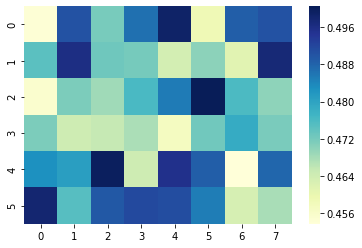

In [15]:
import seaborn as sns

sns.heatmap(plmodel.pruner.get_probs().detach().cpu().numpy(), cmap="YlGnBu")

In [25]:
utils.calculate_bleu(
    data = data_module.test_iter, 
    src_field = data_module.src_field, 
    trg_field = data_module.trg_field,
    model = plmodel.model,
    device=DEVICE
)

0.2512597004366643

## 0.261 bleu vs 0.251 